In [15]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pickle
import libs.utils as utils
import libs.handle.dataset as handle_dataset
import libs.prep_neuropixels.sync as sync


<div style="font-size:80%">

# 異なるデータの同期とは何か？

## ✅ 定義

**異なる記録装置で取得された時系列データを、「同じ時間軸」に揃えること。**

---

## 🔍 抽象的な理解

> **同期とは、異なる時系列データに共通の出来事を手がかりにして、それらの時間軸を重ね合わせる行為である。**

各装置（記録系）はそれぞれ**独立した時間のものさし（クロック）**で動いているため、
単純には「同じ時刻」を比べられない。

そのため、「共通の目印（イベント）」を使って**時間の対応関係（写像）**を作り、
一方の時間軸を他方に変換する必要がある。

---

## 🧠 具体例（直感的）

- A装置：神経活動（スパイク）を記録
- B装置：映像や行動ログを記録
- 同時に「TTLパルス」や「LEDフラッシュ」などの**同期信号**を両方に記録

この共通イベント（同期信号）を使って、

- 「A装置で起きた○秒の出来事」は
- 「B装置の△秒に対応する」

という対応表を作る。

---

## 🔧 実際に行うこと（ざっくり）

1. **共通の目印（同期信号）を検出する**
2. **それぞれの記録装置での時刻を抽出する**
3. **時間の対応関係（写像）を推定する**
   - 線形： `t_new = a * t + b` など
4. **時間軸を変換して、全データを1つの時間基準に揃える**

---

## 🧭 なぜ必要か？

- 時系列をそろえないと、**異なる情報を正しく比較・統合できない**
- 同期がずれていると、**因果関係の誤解**や**解析の破綻**を招く

---

## 📌 まとめ

- 同期とは、**別々の視点から見たデータを「同じ世界の時間軸」で再構成する作業**
- 「同じことが起きた」＝「同じタイムスタンプを持つ」ようにデータを調整する

</div>

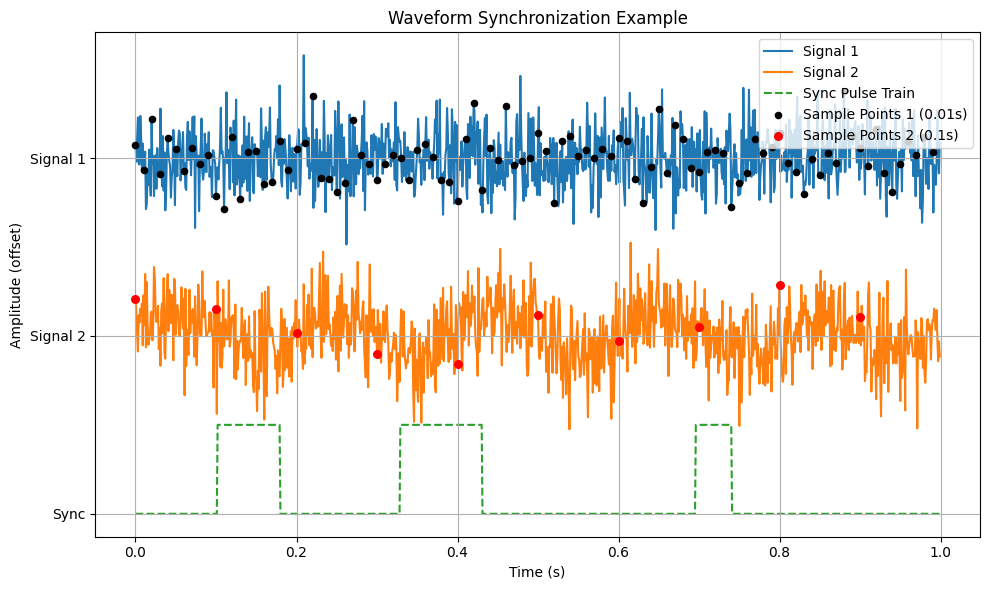

In [16]:
# Time axis
t = np.linspace(0, 1, 1000, endpoint=False)

# Generate two random signals (with noise)
np.random.seed(42)
rand1 = np.random.normal(0, 0.3, size=len(t))
rand2 = np.random.normal(0, 0.3, size=len(t)) + np.sin(2 * np.pi * 5 * t) * 0.2

# Generate rectangular sync pulse train
rect_wave = np.zeros_like(t)
pulse_starts = np.sort(np.random.uniform(0.05, 0.85, size=5))
pulse_widths = np.random.uniform(0.03, 0.08, size=5)
for start, width in zip(pulse_starts, pulse_widths):
    start_idx = int(start * len(t))
    end_idx = int(min(start + width, 1.0) * len(t))
    rect_wave[start_idx:end_idx] = 1

# Vertical offsets for visual separation
offset1 = 4  # Signal 1
offset2 = 2  # Signal 2
offset3 = 0  # Sync

# Define scatter points for each signal
# Signal 1: every 0.01 s
scatter_times_1 = np.arange(0, 1, 0.01)
scatter_indices_1 = (scatter_times_1 * len(t)).astype(int)
scatter_y_1 = rand1[scatter_indices_1] + offset1

# Signal 2: every 0.1 s
scatter_times_2 = np.arange(0, 1, 0.1)
scatter_indices_2 = (scatter_times_2 * len(t)).astype(int)
scatter_y_2 = rand2[scatter_indices_2] + offset2

# Plotting with scatter markers in the front
plt.figure(figsize=(10, 6))

# Plot signals and sync pulse (background layer)
plt.plot(t, rand1 + offset1, label='Signal 1', zorder=1)
plt.plot(t, rand2 + offset2, label='Signal 2', zorder=1)
plt.plot(t, rect_wave + offset3, label='Sync Pulse Train', linestyle='--', zorder=1)

# Plot scatter points (foreground layer)
plt.scatter(scatter_times_1, scatter_y_1, color='black', s=20, marker='o', label='Sample Points 1 (0.01s)', zorder=2)
plt.scatter(scatter_times_2, scatter_y_2, color='red', s=30, marker='o', label='Sample Points 2 (0.1s)', zorder=2)

# Configure plot
plt.title('Waveform Synchronization Example')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (offset)')
plt.yticks([offset3, offset2, offset1], ['Sync', 'Signal 2', 'Signal 1'])
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
session_dir = r'Z:\Temp\RSS033_241101_153102'

In [18]:
session = handle_dataset.Session(session_dir)

In [19]:
# Extract dataset of target probe
i_imec = 0
imec_folder = 'imec'+str(i_imec)
session.add_procTeensy_to_imec(i_imec=i_imec)

In [20]:
path = os.path.join(session_dir, 'processed-data', imec_folder, imec_folder+'_imec0apSY0.npy')
sync_imec = np.load(path)

In [21]:
path = os.path.join(session_dir, 'procTeensy', 'procTeensy.pkl')
with open(path, 'rb') as f:
    procTeensy = pickle.load(f)
sync_procTeensy = procTeensy.get('Sync')
sync_procTeensy = sync.remove_noise(sync_procTeensy)

<Axes: >

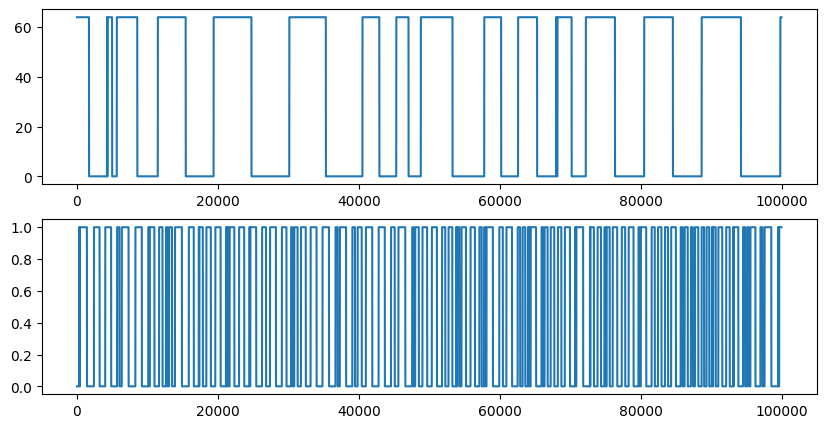

In [22]:
data_range = slice(0, 100000)


plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
sns.lineplot(
    data=sync_imec[data_range],
)
plt.subplot(2, 1, 2)
sns.lineplot(
    data=sync_procTeensy[data_range],
)

In [23]:
def diff_edge(sync_imec, sync_procTeensy):
    """Calculate the difference between two sync signals."""
    edge_idx_imec = np.where(np.diff(sync_imec) != 0)[0]  
    edge_idx_procTeensy = np.where(np.diff(sync_procTeensy) != 0)[0] 

    start, end = 0, min(10000, len(edge_idx_imec), len(edge_idx_procTeensy))  
    diff_edge_idx_imec = np.diff(edge_idx_imec[start:end])
    diff_edge_idx_procTeensy =np.diff(edge_idx_procTeensy[start:end])
    return edge_idx_imec, edge_idx_procTeensy, diff_edge_idx_imec, diff_edge_idx_procTeensy

In [24]:
edge_idx_imec, edge_idx_procTeensy, diff_edge_idx_imec, diff_edge_idx_procTeensy = diff_edge(sync_imec, sync_procTeensy)

<Axes: >

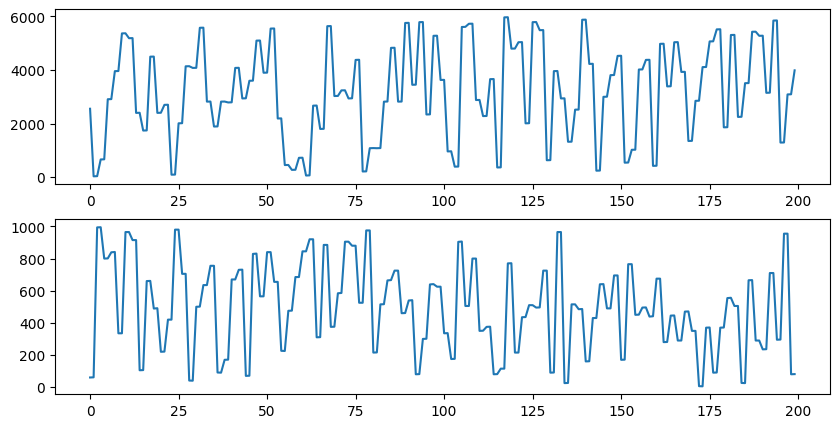

In [ ]:
data_range = slice(0, 200)
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
sns.lineplot(
    data=diff_edge_idx_imec[data_range],
)
plt.subplot(2, 1, 2)
sns.lineplot(
    data=diff_edge_idx_procTeensy[data_range],
)

In [64]:
def edge_idx_filtered(edge_idx_imec, edge_idx_procTeensy):
    start, end = 0, min(10000, len(edge_idx_imec), len(edge_idx_procTeensy))  
    corr = np.correlate(np.diff(edge_idx_imec[start:end]), np.diff(edge_idx_procTeensy[start:end]), mode="full")
    lags = np.arange(-len(edge_idx_imec[start:end]) + 1, len(edge_idx_procTeensy[start:end]))
    lag = lags[np.argmax(corr)]
    edge_idx_imec_filtered = edge_idx_imec[max(0, lag+1):][:len(edge_idx_procTeensy)]
    return edge_idx_imec_filtered, edge_idx_procTeensy

<Axes: >

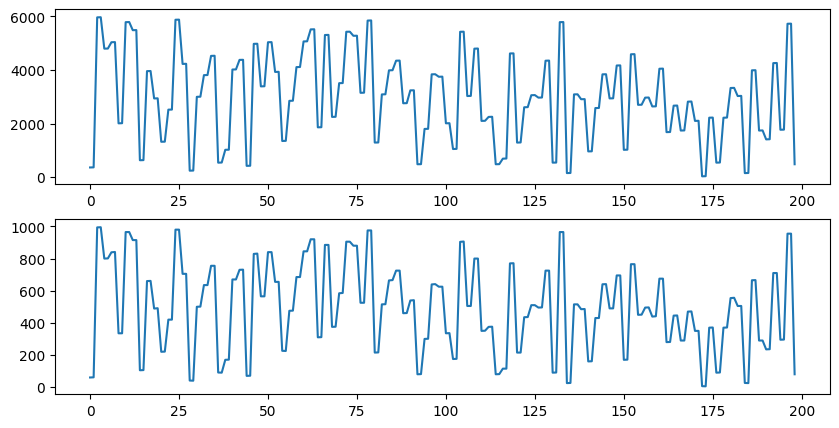

In [67]:
edge_idx_imec_filtered, edge_idx_procTeensy = edge_idx_filtered(edge_idx_imec, edge_idx_procTeensy)

data_range = slice(0, 200)
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
sns.lineplot(
    data=np.diff(edge_idx_imec_filtered[data_range]),
)
plt.subplot(2, 1, 2)
sns.lineplot(
    data=np.diff(edge_idx_procTeensy[data_range]),
)

In [44]:
edge_idx_procTeensy, edge_idx_imec_filtered = sync.process_sync_signals(sync_procTeensy=sync_procTeensy, sync_imec=sync_imec)

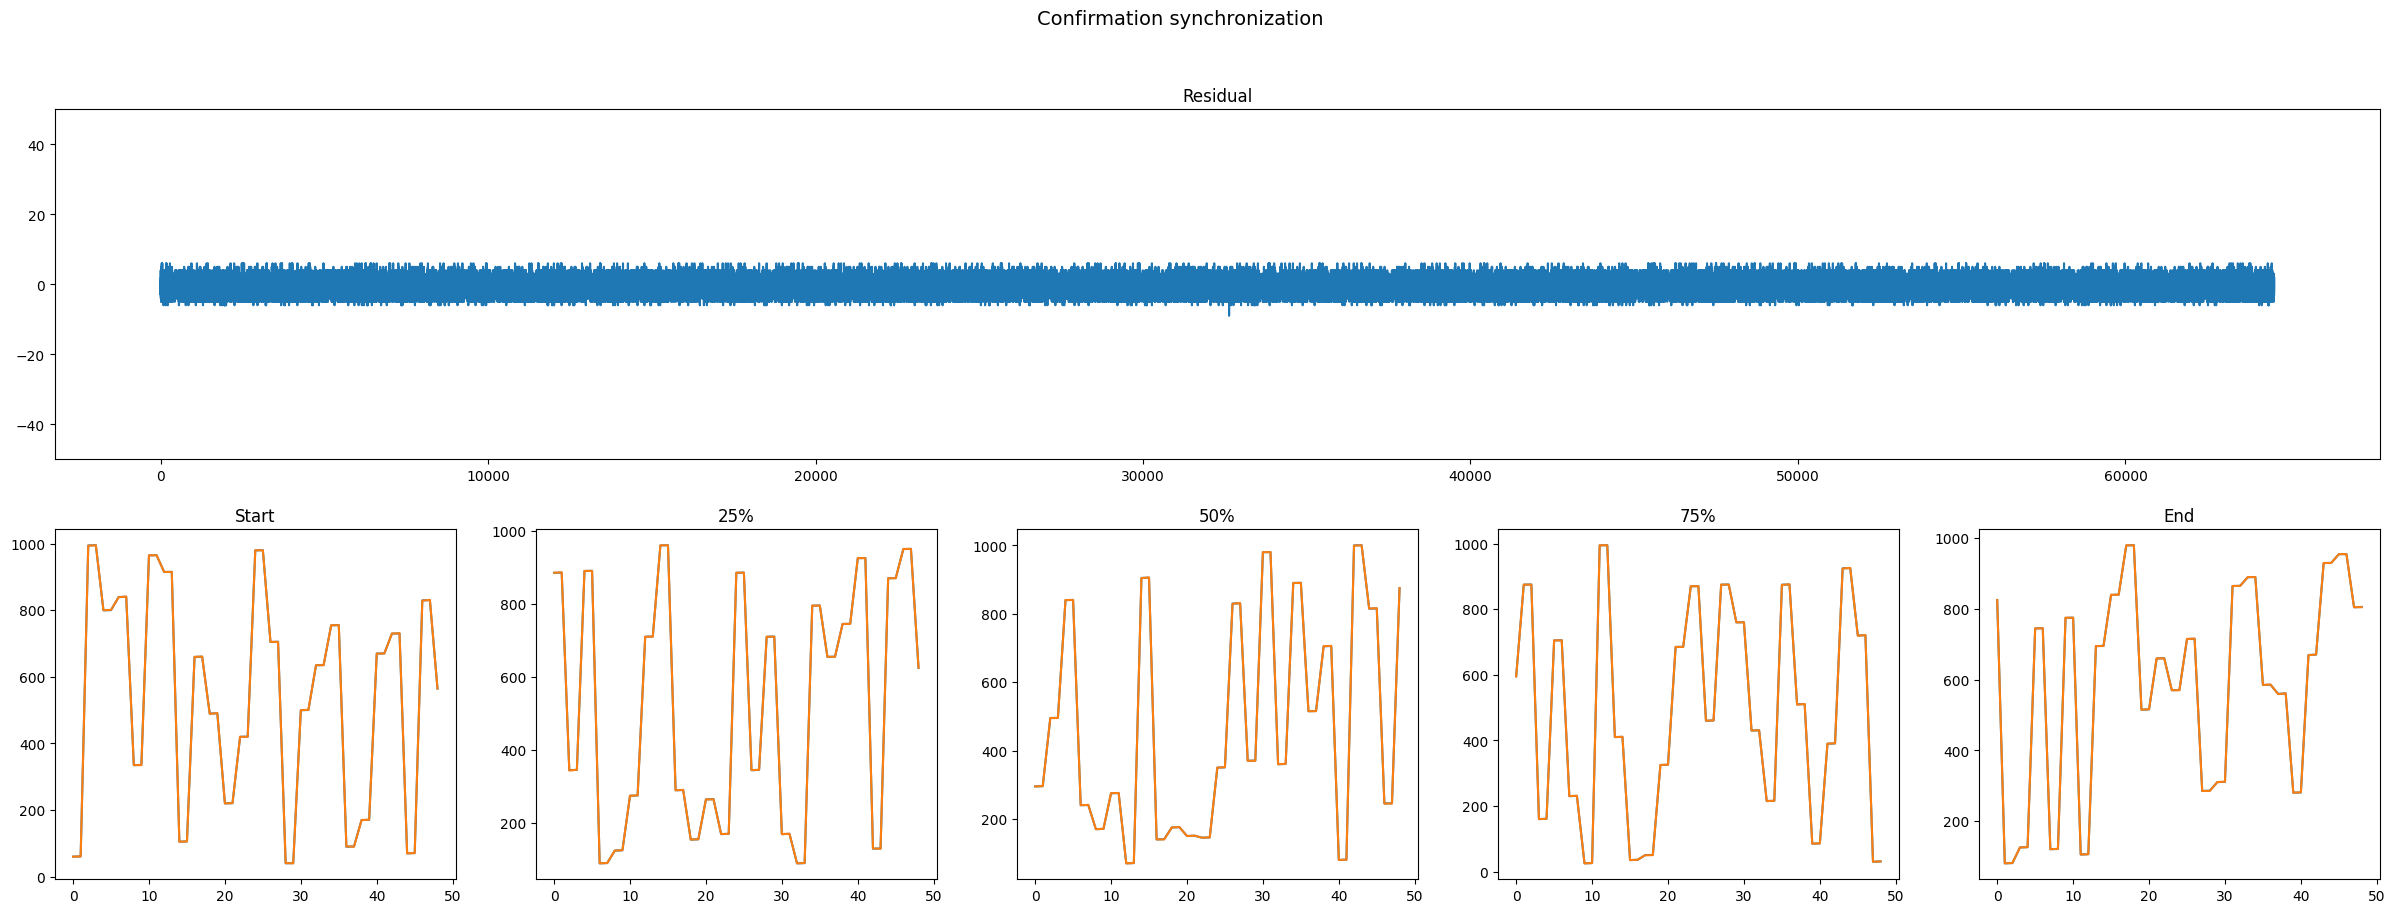

In [68]:
sync.plot_sync_confirm(edge_idx_procTeensy=edge_idx_procTeensy, edge_idx_imec_filtered=edge_idx_imec_filtered)

In [74]:
df = pd.DataFrame({
    'procTeensy': edge_idx_procTeensy ,
    'imec': edge_idx_imec_filtered,
})
df

,procTeensy,imec
0,297,346896
1,357,347257
2,418,347622
3,1412,353589
4,2407,359561
...,...,...
64538,32336368,194362800
64539,32337323,194368528
64540,32338278,194374260
64541,32339083,194379088


In [ ]:
i = 0
row_pt = np.arange(edge_idx_procTeensy[i], edge_idx_procTeensy[i+1])
row_imec = np.linspace(edge_idx_imec_filtered[i], edge_idx_imec_filtered[i+1] - 6, len(row_pt))  

df = pd.DataFrame({
    'procTeensy': row_pt,
    'imec': row_imec,
})
df

,procTeensy,imec
0,297,346896.000000
1,298,346902.016949
2,299,346908.033898
3,300,346914.050847
4,301,346920.067797
5,302,346926.084746
6,303,346932.101695
7,304,346938.118644
8,305,346944.135593
9,306,346950.152542


In [88]:
procTeensy_to_imec = np.zeros(np.max(edge_idx_procTeensy) + 1)

for i in range(len(edge_idx_procTeensy) - 1):
    row_pt = np.arange(edge_idx_procTeensy[i], edge_idx_procTeensy[i+1])  
    row_imec = np.linspace(edge_idx_imec_filtered[i], edge_idx_imec_filtered[i+1] - 6, len(row_pt))  
    procTeensy_to_imec[row_pt.astype(int)] = row_imec  

df = pd.DataFrame(procTeensy_to_imec)
df

,0
0,0.000000e+00
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
...,...
32339884,1.943839e+08
32339885,1.943839e+08
32339886,1.943839e+08
32339887,1.943839e+08


In [90]:
# Normalize by sampling rate
sampling_rate = 30000  # Hz
procTeensy_to_imec = procTeensy_to_imec/sampling_rate
df = pd.DataFrame(procTeensy_to_imec)
df

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
32339884,0.215982
32339885,0.215982
32339886,0.215982
32339887,0.215982
